In [ ]:
from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed
#set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform
from tensorflow import keras
from sklearn.utils import shuffle
#from sklearn.metrics import confusion_matrix
#from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive, files

drive.mount('/drive')

Mounted at /drive


In [ ]:
os.listdir('/drive/My Drive/training1/')

['Glaucoma', 'Normal', 'Myopia', 'DiabeticRetinopathy']

In [ ]:
folder_list = os.listdir('/drive/My Drive/training1/')
path_1 = '/drive/My Drive/training1/'
total_images = 0

for folder in folder_list:
  #/drive/My Drive/dataset/train/
    path = '/drive/My Drive/training1/' + str(folder)
    images_list = os.listdir(path)
    
    num_images = len(images_list)
    
    total_images = total_images + num_images
    print(str(folder) + ':' + ' ' + str(num_images))
    
print('\n')
print('Total Images: ', total_images)
    

Glaucoma: 501
Normal: 510
Myopia: 502
DiabeticRetinopathy: 539


Total Images:  2052


In [ ]:
all_images_dir = 'all_images'
os.mkdir(all_images_dir)

In [ ]:
import shutil
folder_list = os.listdir(path_1)

for folder in folder_list:
    
    # create a path to the folder
    path = path_1+ str(folder)

    # create a list of all files in the folder
    file_list = os.listdir(path)

    # move the 0 images to all_images_dir
    for fname in file_list:

        # source path to image
        src = os.path.join(path,fname)
        

        # Change the file name because many images have the same file name.
        # Add the folder name to the existing file name.
        new_fname = str(folder) + '_' + fname
        
        # destination path to image
        dst = os.path.join(all_images_dir,new_fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
# Check how many images are in all_images_dir.
# Should be 5539.

len(os.listdir('all_images'))

2052

In [ ]:
# Get a list of all images in the all_images_dir folder.
image_list = os.listdir('all_images')

# Create the dataframe.
df_file = pd.DataFrame(image_list, columns=['image_id'])
def extract_target(x):
    # split into a list
    a = x.split('_')
    #b = y.split('_')
    # the target is the first index in the list
    target = a[0]

    #Labels=b[0:4]
    
    return target

# create a new column called 'target'
df_file['Classes'] = df_file['image_id'].apply(extract_target)
#df_data['DiabeticRetinopathy','Myopia','Glaucoma','Normal'].apply(extract_target)
dum_df = pd.get_dummies(df_file.Classes, prefix=None )
#df_data = df_data.join(dum_df)
dum_df = pd.get_dummies(df_file.Classes, prefix=None )
df_data =df_file.join(dum_df)

In [ ]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=plt.imread(file)
            ax[i, j].imshow(im,cmap="gray")
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

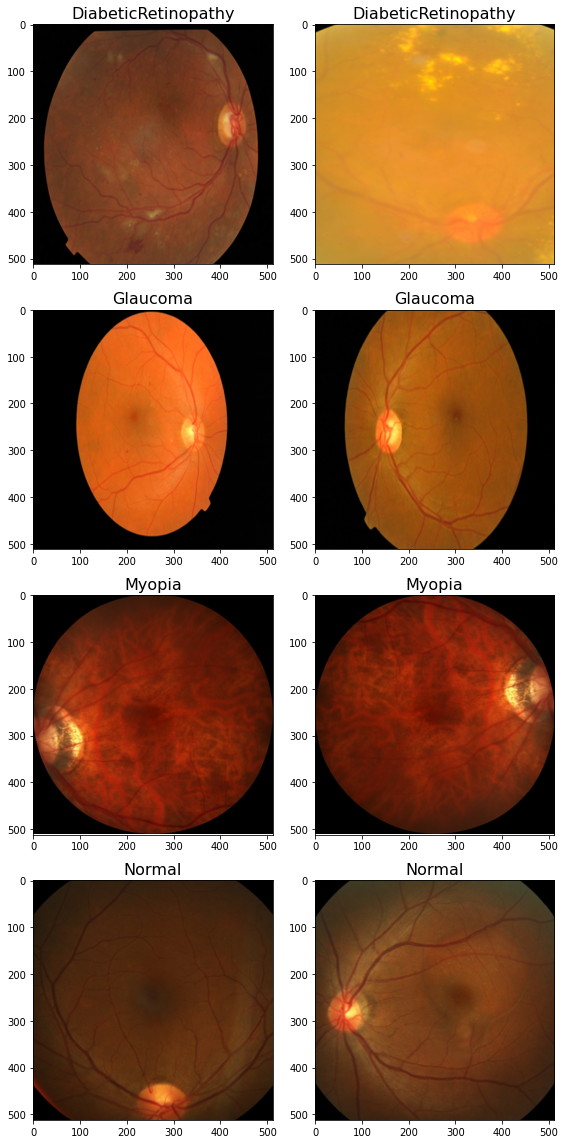

In [ ]:
IMAGE_PATH = 'all_images/'
draw_category_images('Classes',2, df_data, IMAGE_PATH)

In [ ]:
df_data['Classes'].value_counts()
num_labels=["DiabeticRetinopathy","Glaucoma","Myopia","Normal"]

In [ ]:
# Initiate the train and test generators with data Augumentation
from imgaug import augmenters as iaa
# Initiate the train and test generators with data Augumentation
sometimes = lambda aug: iaa.Sometimes(1, aug)
seq = iaa.Sequential([
                      iaa.AllChannelsCLAHE(),
                      #iaa.AllChannelsHistogramEqualization()
                      #iaa.AllChannelsHistogramEqualization(),
            
                    ])

In [ ]:
from tqdm import tqdm
from keras.preprocessing import image
train_image = []

for i in tqdm(range(df_data.shape[0])):
    scr= cv2.imread('all_images/'+df_data['image_id'][i])
    grayA = cv2.cvtColor(scr, cv2.COLOR_RGB2GRAY)
    images = cv2.resize(grayA ,(256,256))
    aug_img=seq(images=images)
    aug_img = image.img_to_array(aug_img)
    aug_img = aug_img/255 
    train_image.append(aug_img)
X = np.array(train_image)

100%|██████████| 2052/2052 [00:22<00:00, 92.25it/s]


In [ ]:
X.shape

(2052, 256, 256, 1)

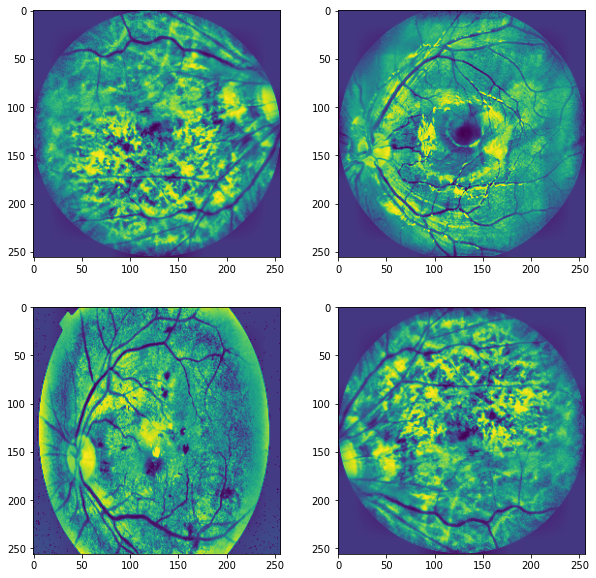

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_image[i][:,:,0])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
#df_data['Classes'][:4]
y = np.array(df_data.drop(['image_id', 'Classes'],axis=1))
y.shape

(2052, 4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
# convert the labels from integers to vectors, converting the data
# type to floats so we can apply label smoothing
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_train = y_train.astype("float")
y_test = y_test.astype("float")

In [ ]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 128
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]
EPOCHS = 30
PATIENCE = 5
QUEUE_SIZE = 25
#TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200

In [ ]:
image_size = X_train.shape[1]

In [ ]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow(
         X_train,
         y_train, 
         batch_size=BATCH_SIZE,
        shuffle = True,
    )
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow(
                X_test,
                y_test,
                batch_size = BATCH_SIZE,
                shuffle = True,
    )

In [ ]:
# w = 10
# h = 10
# fig = plt.figure(figsize=(10, 10))
# columns = 2
# rows = 2
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(X_train[i][:,:,0])
#     print(X_train[i].shape)
# plt.show()

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

In [ ]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 1), name = "Input")

depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", 
                               activation = "relu", name = "DwC_1")(inputs)
point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)


depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)

depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)


depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)


depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)

global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)

concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])

dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1")(dropout_1)

dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dense_2 = Dense(len(num_labels), activation = "softmax", name = "Output")(dropout_2)

In [ ]:
# # build the model by supplying inputs/outputs
from tensorflow import keras
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")
keras.utils.plot_model(
    model,
    to_file="/drive/My Drive/dataeye/GMD0HE.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    dpi = PLOTS_DPI,
    show_layer_activations=True,
)

# network model in text
model.summary()

Model: "Plant_Leaf"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 DwC_1 (DepthwiseConv2D)        (None, 256, 256, 8)  40          ['Input[0][0]']                  
                                                                                                  
 PwC_1 (Conv2D)                 (None, 256, 256, 32  288         ['DwC_1[0][0]']                  
                                )                                                                 
                                                                                         

In [ ]:
from tensorflow.keras import optimizers
from keras import backend as K
from tensorflow.keras.optimizers import Adadelta , SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from matplotlib.colors import NoNorm

earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)

model.save('/drive/My Drive/dataeye/save_gmd021000')

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    max_queue_size = QUEUE_SIZE,
    callbacks = [earlyStop]
)

INFO:tensorflow:Assets written to: /drive/My Drive/dataeye/save_gmd021000/assets


INFO:tensorflow:Assets written to: /drive/My Drive/dataeye/save_gmd021000/assets


Epoch 1/30
13/13 [==============================] - 24s 1s/step - loss: 1.3869 - accuracy: 0.2495 - val_loss: 1.3874 - val_accuracy: 0.2339
Epoch 2/30
13/13 [==============================] - 19s 1s/step - loss: 1.3860 - accuracy: 0.2508 - val_loss: 1.3876 - val_accuracy: 0.2339
Epoch 3/30
13/13 [==============================] - 19s 1s/step - loss: 1.3862 - accuracy: 0.2567 - val_loss: 1.3869 - val_accuracy: 0.2573
Epoch 4/30
13/13 [==============================] - 19s 1s/step - loss: 1.3859 - accuracy: 0.2645 - val_loss: 1.3858 - val_accuracy: 0.2573
Epoch 5/30
 5/13 [==========>...................] - ETA: 9s - loss: 1.3856 - accuracy: 0.2816 

KeyboardInterrupt: ignored

In [ ]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.savefig('/drive/My Drive/dataeye/'+'performance.png')

In [ ]:
plot_history(history)

In [ ]:
model.metrics_names

In [ ]:
val_loss, val_accuracy = \
evaluate=model.evaluate(X_test, y_test,batch_size=32)
print('test_model:', val_loss)
print('val_acc:', val_accuracy)

In [ ]:
predictions=np.argmax(model.predict(X_test), axis=-1)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
labelNames=['DiabeticRetinopathy','Myopia', 'Glaucoma','Normal']
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=-1),
  predictions.argmax(axis=-1), target_names=labelNames))

In [ ]:
from keras.preprocessing import image
path='/drive/My Drive/dataset/train/Normal/07.png'
scr= cv2.imread(path)
#grayA = cv2.cvtColor(scr, cv2.COLOR_RGB2GRAY)
images = cv2.resize(scr,(224,224))
#aug_img=seq(images=images)
aug_img = image.img_to_array(images)
aug_img = aug_img/255

In [ ]:
#classes= np.array((df_data.columns[2:]))
classes=['DiabeticRetinopathy','Myopia', 'Glaucoma','Normal']

proba = model.predict(aug_img.reshape(1,224,224,3))
top_4 = np.argsort(proba[0],kind ='heapsort', axis = -1)[:-4:-1]
reusult=[]
for i in range(3):
    print("{}".format(classes[top_4[i]])+" ({:.3})".format(proba[0][top_4[i]]))
    reusult.append("{}".format(classes[top_4[i]])+" ({:.3})".format(proba[0][top_4[i]]))
plt.figure(figsize=(6,6))    
plt.imshow(aug_img[:,:,0])
#plt.figure(figsize=(10,10))